In [2]:
!pip install mean_average_precision

Importing Python libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import Xception, VGG16, ResNet152V2, InceptionResNetV2, MobileNetV2, DenseNet201, NASNetLarge, EfficientNetB7
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from mean_average_precision import MetricBuilder

In [7]:
path = 'crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'

image_list = [x for x in os.listdir(path) if x.endswith('.jpeg')]
label_list = [x for x in os.listdir(path) if x.endswith('.txt')]
image_list.sort()
label_list.sort()

In [8]:
image_list_check = [x[:-5] for x in image_list]
label_list_check = [x[:-4] for x in label_list]

image_list_check == label_list_check

True

Extracting Information from labels

In [9]:
df = pd.DataFrame(columns=['image_file', 'class', 'x_center', 'y_center', 'width', 'height'])
df['image_file'] = image_list
i=0
for file in df['image_file']:
    label = open(path + file[:-5] +'.txt', 'r').readline().split()
    df.loc[i, 'class'] = int(label[0])
    df.loc[i, 'x_center'] = float(label[1])
    df.loc[i, 'y_center'] = float(label[2])
    df.loc[i, 'width'] = float(label[3])
    df.loc[i, 'height'] = float(label[4])
    i +=1

df.head()

,image_file,class,x_center,y_center,width,height
0,agri_0_1009.jpeg,1,0.608398,0.498047,0.541016,0.53125
1,agri_0_1017.jpeg,1,0.496094,0.384766,0.960938,0.753906
2,agri_0_1018.jpeg,1,0.445312,0.483398,0.808594,0.634766
3,agri_0_1020.jpeg,1,0.494141,0.350586,0.730469,0.611328
4,agri_0_1024.jpeg,1,0.601562,0.448242,0.570312,0.595703


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_file  1300 non-null   object
 1   class       1300 non-null   object
 2   x_center    1300 non-null   object
 3   y_center    1300 non-null   object
 4   width       1300 non-null   object
 5   height      1300 non-null   object
dtypes: object(6)
memory usage: 61.1+ KB


Formatting Data for Modeling
Once the data is in a dataframe we conrvet from YOLO to Pascal VOC format. The Pascal VOC annotation format is as follows:

(Image File Name, Image Width, Image Height, Bounding Box "X" Minimum, Bounding Box "Y" Minimum, Bounding Box "X" Maximum, Bounding Box "Y" Maximum, Class Label)

In [11]:
df_pas_voc = pd.DataFrame(columns = ['filename', 'width', 'height', 'x_min', 'y_min', 'x_max', 'y_max', 'class'])

df_pas_voc['filename'] = df['image_file']
df_pas_voc['class'] = df['class']
df_pas_voc['width'] = 512
df_pas_voc['height'] = 512

for i in range(len(df_pas_voc)):
    df_pas_voc.loc[i, 'x_min'] = df.loc[i, 'x_center'] - (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_min'] = df.loc[i, 'y_center'] - (df.loc[i, 'height']/2)
    df_pas_voc.loc[i, 'x_max'] = df.loc[i, 'x_center'] + (df.loc[i, 'width']/2)
    df_pas_voc.loc[i, 'y_max'] = df.loc[i, 'y_center'] + (df.loc[i, 'height']/2)
df_pas_voc.head()

,filename,width,height,x_min,y_min,x_max,y_max,class
0,agri_0_1009.jpeg,512,512,0.33789,0.232422,0.878906,0.763672,1
1,agri_0_1017.jpeg,512,512,0.015625,0.007813,0.976563,0.761719,1
2,agri_0_1018.jpeg,512,512,0.041015,0.166015,0.849609,0.800781,1
3,agri_0_1020.jpeg,512,512,0.128906,0.044922,0.859376,0.65625,1
4,agri_0_1024.jpeg,512,512,0.316406,0.15039,0.886718,0.746093,1


We then load the images, reduce their size to 224x224 and scale their pixel intensities to between 0 and 1 to reduce the computational requirements during modeling. Then we format the image data into a numpy array which necessary for modeling.

In [12]:
data = []
for filename in df_pas_voc['filename']:
    image = load_img(path + filename, target_size=(224, 224))
    image = img_to_array(image)
    data.append(image)
data = np.array(data, dtype='float32') / 255.0
data

array([[[[0.9254902 , 0.92941177, 0.8666667 ],
         [0.9098039 , 0.9019608 , 0.84313726],
         [0.9764706 , 0.9607843 , 0.9137255 ],
         ...,
         [0.45882353, 0.40784314, 0.43529412],
         [0.47843137, 0.41568628, 0.45490196],
         [0.4745098 , 0.40784314, 0.44705883]],

        [[0.8901961 , 0.89411765, 0.83137256],
         [0.8901961 , 0.88235295, 0.83137256],
         [0.9647059 , 0.9490196 , 0.90588236],
         ...,
         [0.47058824, 0.41960785, 0.44705883],
         [0.47058824, 0.40784314, 0.44705883],
         [0.4745098 , 0.4117647 , 0.4509804 ]],

        [[0.92156863, 0.9254902 , 0.87058824],
         [0.9254902 , 0.91764706, 0.8666667 ],
         [0.94509804, 0.92941177, 0.8862745 ],
         ...,
         [0.60784316, 0.5647059 , 0.5882353 ],
         [0.61960787, 0.5764706 , 0.60784316],
         [0.6392157 , 0.5882353 , 0.62352943]],

        ...,

        [[0.65882355, 0.6431373 , 0.60784316],
         [0.6745098 , 0.64705884, 0.6156863 ]

In [13]:
labels = []
for i in range(len(df_pas_voc)):
    labels.append(df_pas_voc.loc[i, 'class'])
labels = np.array(labels)
labels = to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [14]:
bboxes = []
for i in range(len(df_pas_voc)):
    bboxes.append((df_pas_voc.loc[i, 'x_min'], df_pas_voc.loc[i, 'y_min'], df_pas_voc.loc[i, 'x_max'], df_pas_voc.loc[i, 'y_max']))
bboxes = np.array(bboxes, dtype="float32")
bboxes

array([[0.33789  , 0.232422 , 0.878906 , 0.763672 ],
       [0.015625 , 0.007813 , 0.976563 , 0.761719 ],
       [0.041015 , 0.166015 , 0.849609 , 0.800781 ],
       ...,
       [0.103516 , 0.048828 , 0.892578 , 0.669922 ],
       [0.115234 , 0.15625  , 0.888672 , 0.65625  ],
       [0.087891 , 0.2597655, 0.445313 , 0.6093745]], dtype=float32)

In [15]:
image_paths = []
for i in range(len(df_pas_voc)):
    image_paths.append((path + df_pas_voc.loc[i, "filename"]))

image_paths = np.array(image_paths)
image_paths

array(['/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1009.jpeg',
       '/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1017.jpeg',
       '/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_1018.jpeg',
       ...,
       '/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_9960.jpeg',
       '/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_9963.jpeg',
       '/content/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/agri_0_9971.jpeg'],
      dtype='<U89')

Train Test Split
Next we split our data into training and testing sets using sklearns train_test_split function. The training set contains 80% of the original data and the test set contains 20%.

In [16]:
split1 = train_test_split(data, labels, bboxes, image_paths, test_size=0.2, random_state=42)

In [17]:
(x_train_0, x_test) = split1[:2]
(labels_train_0, labels_test) = split1[2:4]
(bboxes_train_0, bboxes_test) = split1[4:6]
(image_paths_train_0, image_paths_test) = split1[6:]

In [18]:
split2 = train_test_split(x_train_0, labels_train_0, bboxes_train_0, image_paths_train_0, test_size=0.1, random_state=42)

(x_train, x_val) = split2[:2]
(labels_train, labels_val) = split2[2:4]
(bboxes_train, bboxes_val) = split2[4:6]
(image_paths_train, image_paths_val) = split2[6:]

In [19]:
print(f"x_train shape : {x_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"labels_train shape : {labels_train.shape}")
print(f"labels_val shape : {labels_val.shape}")
print(f"labels_test shape : {labels_test.shape}")
print(f"bboxes_train shape : {bboxes_train.shape}")
print(f"bboxes_val shape : {bboxes_val.shape}")
print(f"bboxes_test shape : {bboxes_test.shape}")
print(f"image_paths_train shape : {image_paths_train.shape}")
print(f"image_paths_val shape : {image_paths_val.shape}")
print(f"image_paths_test shape : {image_paths_test.shape}")

x_train shape : (936, 224, 224, 3)
x_val shape : (104, 224, 224, 3)
x_test shape : (260, 224, 224, 3)
labels_train shape : (936, 2)
labels_val shape : (104, 2)
labels_test shape : (260, 2)
bboxes_train shape : (936, 4)
bboxes_val shape : (104, 4)
bboxes_test shape : (260, 4)
image_paths_train shape : (936,)
image_paths_val shape : (104,)
image_paths_test shape : (260,)


In [20]:
import os
os.makedirs('Plots/Loss_Plots')
os.makedirs('Plots/Accuracy_Plots')

Creating Evaluation Functions

Next we create some useful functions that will help us plot the loss and accuracy of our different model iterations during training.

In [21]:
def plot_loss(model_name, num_epochs):
    loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
    fig.tight_layout(pad=5.0)
    for (i, l) in enumerate(loss_names):
        title = "Loss for {}".format(l) if l != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel("Loss")
        ax[i].plot(N, H.history[l], label=l)
        ax[i].plot(N, H.history["val_" + l], label="val_" + l)
        ax[i].legend()

    print(f"Final epoch training total loss during {model_name} training: {H.history['loss'][num_epochs-1]}")
    print(f"Final epoch training class label loss during {model_name} training: {H.history['class_label_loss'][num_epochs-1]}")
    print(f"Final epoch training bounding box loss during {model_name} training: {H.history['bounding_box_loss'][num_epochs-1]}")

    print(f"Final epoch validation total loss during {model_name} training: {H.history['val_loss'][num_epochs-1]}")
    print(f"Final epoch validation class label loss during {model_name} training: {H.history['val_class_label_loss'][num_epochs-1]}")
    print(f"Final epoch validation bounding box loss during {model_name} training: {H.history['val_bounding_box_loss'][num_epochs-1]}")

    plt.savefig(f"Plots/Loss_Plots/{model_name}_training_loss")

    return plt

In [22]:
def plot_accuracy(model_name, num_epochs):
    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
    plt.plot(N, H.history["val_class_label_accuracy"],
    label="class_label_val_acc")
    plt.title("Class Label Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.savefig(f"Plots/Accuracy_Plots/{model_name}_training_label_accuracy");

    print(f"Final epoch training class label accurracy during {model_name} training: {H.history['class_label_accuracy'][num_epochs-1]}")
    print(f"Final epoch validation class label accurracy during {model_name} training: {H.history['val_class_label_accuracy'][num_epochs-1]}")

    return plt

Additionally, we created a set of functions that will help us calculate the mean average precision scores according to Pascal VOC and COCO formats as well as the average inference time to predict an image's labels. Ultiamtely, these metrics will help us evaluate a model's performance, driving the iteration process in order to select the best model.

In [23]:
def evaluate_val(model, model_name):
    preds = []
    inf_time = []

    for i in range(len(image_paths_val)):
        image = load_img(image_paths_val[i], target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)

        start_time = time.time()
        (bboxPred, labelPred) = model.predict(image)
        stop_time= time.time()
        duration = stop_time - start_time
        inf_time.append(duration)

        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        lbl = int(np.argmax(labelPred, axis=1))
        cf = np.max(labelPred)
        preds.append([startX, startY, endX, endY, lbl, cf])

    preds = np.array(preds)
    avg_inf_time = np.mean(inf_time)

    gts = []

    for i in range(len(image_paths_val)):
        gt_label = int(np.argmax(labels_val[i]))
        (gt_startX, gt_startY, gt_endX, gt_endY) = bboxes_val[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, gt_label, 0, 0])


    gts = np.array(gts)

    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=2)
    for i in range(len(image_paths_val)):
        map_fn.add(preds, gts)


    voc_pascal_map = map_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    voc_pascal_map_allpts = map_fn.value(iou_thresholds=0.5)['mAP']
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']

    print(f"VOC PASCAL mAP for {model_name} validation data: {voc_pascal_map}")
    print(f"VOC PASCAL mAP in all points for {model_name} validation data: {voc_pascal_map_allpts}")
    print(f"COCO mAP for {model_name} validation data: {coco_map}")
    print(f"Average inference time for {model_name} validation data: {avg_inf_time}")

    result_val = {'model': model_name, 'voc_pascal_map': voc_pascal_map, 'voc_pascal_map_allpts': voc_pascal_map_allpts, 'coco_map': coco_map, 'avg_inf_time': avg_inf_time}
    return result_val

In [24]:
def evaluate_test(model, model_name):
    preds = []
    inf_time = []

    for i in range(len(image_paths_test)):
        image = load_img(image_paths_test[i], target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = np.expand_dims(image, axis=0)

        start_time = time.time()
        (bboxPred, labelPred) = model.predict(image)
        stop_time= time.time()
        duration = stop_time - start_time
        inf_time.append(duration)

        (startX, startY, endX, endY) = bboxPred[0]
        startX = int(startX * 224)
        startY = int(startY * 224)
        endX = int(endX * 224)
        endY = int(endY * 224)
        lbl = int(np.argmax(labelPred, axis=1))
        cf = np.max(labelPred)
        preds.append([startX, startY, endX, endY, lbl, cf])

    preds = np.array(preds)
    avg_inf_time = np.mean(inf_time)

    gts = []

    for i in range(len(image_paths_test)):
        gt_label = int(np.argmax(labels_test[i]))
        (gt_startX, gt_startY, gt_endX, gt_endY) = bboxes_test[i]
        gt_startX = int(gt_startX * 224)
        gt_startY = int(gt_startY * 224)
        gt_endX = int(gt_endX * 224)
        gt_endY = int(gt_endY * 224)
        gts.append([gt_startX, gt_startY, gt_endX, gt_endY, gt_label, 0, 0])

    gts = np.array(gts)

    map_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=2)
    for i in range(len(image_paths_test)):
        map_fn.add(preds, gts)

    voc_pascal_map = map_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']
    voc_pascal_map_allpts = map_fn.value(iou_thresholds=0.5)['mAP']
    coco_map = map_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']

    print(f"VOC PASCAL mAP for {model_name} test data: {voc_pascal_map}")
    print(f"VOC PASCAL mAP in all points for {model_name} test data: {voc_pascal_map_allpts}")
    print(f"COCO mAP for {model_name} test data: {coco_map}")
    print(f"Average inference time for {model_name} test data: {avg_inf_time}")


    result_test = {'model': model_name, 'voc_pascal_map': voc_pascal_map, 'voc_pascal_map_allpts': voc_pascal_map_allpts, 'coco_map': coco_map, 'avg_inf_time': avg_inf_time}
    return result_test

We created two data frames, one to store the mean average precion scores and average inference time during the modeling process and the other to store the final models evualuation metrics for the test set.

In [25]:
df_results_val= pd.DataFrame(columns = ['model', 'voc_pascal_map', 'voc_pascal_map_allpts', 'coco_map', 'avg_inf_time'])

In [26]:
df_results_test = pd.DataFrame(columns = ['model', 'voc_pascal_map', 'voc_pascal_map_allpts', 'coco_map', 'avg_inf_time'])

Model Traning

Custom Model Backbone

In [1]:
input_layer = Input(shape=(224,224,3), name='input_layer')
conv1 = Conv2D(32, (3,3), activation='relu')(input_layer)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3,3), activation='relu')(pool1)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3,3), activation='relu')(pool2)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3,3), activation='relu')(pool3)
pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3,3), activation='relu')(pool4)
pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
flat = Flatten()(pool5)

NameError: name 'Input' is not defined

Model Heads V1

In [28]:
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dense(64, activation="relu")(bbox_head1)
bbox_head3 = Dense(32, activation="relu")(bbox_head2)
bbox_head_v1 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head3)
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v1 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

Model Heads V2

In [ ]:
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dropout(0.5)(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head6 = Dropout(0.5)(bbox_head5)
bbox_head_v2 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head6)
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(512, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head_v2 = Dense(2, activation="sigmoid", name="class_label")(class_head6)

Model Heads V3

In [ ]:
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v3 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v3 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

Model Heads V4

In [ ]:
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v4 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(512, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head5 = Dense(256, activation="relu")(class_head4)
class_head6 = Dropout(0.5)(class_head5)
class_head7 = Dense(128, activation="relu")(class_head6)
class_head8 = Dropout(0.5)(class_head7)
class_head_v4 = Dense(2, activation="sigmoid", name="class_label")(class_head8)

Model Heads V5

In [ ]:
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(128, activation="relu")(bbox_head2)
bbox_head4 = Dense(64, activation="relu")(bbox_head3)
bbox_head5 = Dense(32, activation="relu")(bbox_head4)
bbox_head_v5 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head5)
class_head1 = Dense(512, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(256, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v5 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

Model Heads V6

In [ ]:
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dense(128, activation="relu")(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v6 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)
class_head1 = Dense(256, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(128, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v6 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

Model Heads V7

In [ ]:
bbox_head1 = Dense(128, activation="relu")(flat)
bbox_head2 = Dropout(0.5)(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v7 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)
class_head1 = Dense(128, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(64, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v7 = Dense(2, activation="sigmoid", name="class_label")(class_head4)

Configuration Parameters

Below are the parameters for the model training process.

In [35]:
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}
opt = Adam(learning_rate = 0.0001)
batch_size = 32
epochs = 30

We created one custom simple model "backbone" which was trained on the crop and weed dataset. The "backbones" were connected to a pair of different model "heads", one for predicting class lables and one for predicting bounding box labels.

VGG16 model

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg16.trainable = False

flatten = vgg16.output
flat = Flatten()(flatten)
bbox_head1 = Dense(256, activation="relu")(flat)
bbox_head2 = Dense(128, activation="relu")(bbox_head1)
bbox_head3 = Dense(64, activation="relu")(bbox_head2)
bbox_head4 = Dense(32, activation="relu")(bbox_head3)
bbox_head_v6 = Dense(4, activation="sigmoid", name="bounding_box")(bbox_head4)
class_head1 = Dense(256, activation="relu")(flat)
class_head2 = Dropout(0.5)(class_head1)
class_head3 = Dense(128, activation="relu")(class_head2)
class_head4 = Dropout(0.5)(class_head3)
class_head_v6 = Dense(2, activation="sigmoid", name="class_label")(class_head4)
vgg16_model_v6 = Model(inputs=vgg16.input, outputs=(bbox_head_v6, class_head_v6))
losses = {"class_label": "binary_crossentropy", "bounding_box": "mean_squared_error"}
loss_weights = {"class_label": 1.0, "bounding_box": 1.0}
opt = Adam(learning_rate = 0.0001)
vgg16_model_v6.compile(
    optimizer=opt,
    loss={
        "class_label": "binary_crossentropy",
        "bounding_box": "mean_squared_error"
    },
    metrics={
        "class_label": ["accuracy"],
        "bounding_box": ["mse"]
    },
    loss_weights={
        "class_label": 1.0,
        "bounding_box": 1.0
    }
)
print(vgg16_model_v6.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 27,636,774 (105.43 MB)

 Trainable params: 12,922,086 (49.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
train_targets = {"class_label": labels_train, "bounding_box": bboxes_train}
val_targets = {"class_label": labels_val, "bounding_box": bboxes_val}
H = vgg16_model_v6.fit(x_train, train_targets, validation_data=(x_val, val_targets), batch_size=batch_size, epochs=epochs, verbose=1)

vgg16_model_v6.save('Models/vgg16_model_v6.h5', save_format='h5')

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 473ms/step - bounding_box_loss: 0.0503 - bounding_box_mse: 0.0503 - class_label_accuracy: 0.7775 - class_label_loss: 0.5224 - loss: 0.5732 - val_bounding_box_loss: 0.0123 - val_bounding_box_mse: 0.0133 - val_class_label_accuracy: 0.9231 - val_class_label_loss: 0.1745 - val_loss: 0.2172
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - bounding_box_loss: 0.0137 - bounding_box_mse: 0.0137 - class_label_accuracy: 0.9207 - class_label_loss: 0.2451 - loss: 0.2588 - val_bounding_box_loss: 0.0101 - val_bounding_box_mse: 0.0108 - val_class_label_accuracy: 0.9423 - val_class_label_loss: 0.1864 - val_loss: 0.2277
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - bounding_box_loss: 0.0094 - bounding_box_mse: 0.0094 - class_label_accuracy: 0.9523 - class_label_loss: 0.1987 - loss: 0.2083 - val_bounding_box_loss: 0.0089 - val_bounding_box_mse: 0.0097 - val_class_label_accuracy: 0.9423 - val_class_label_loss: 0.1797 - val_loss: 0.2164
Epoch 4/30
30/3

Loss plot

Final epoch training total loss during vgg16_model_v6 training: 0.040416184812784195
Final epoch training class label loss during vgg16_model_v6 training: 0.038169946521520615
Final epoch training bounding box loss during vgg16_model_v6 training: 0.0014306381344795227
Final epoch validation total loss during vgg16_model_v6 training: 0.42701414227485657
Final epoch validation class label loss during vgg16_model_v6 training: 0.46538716554641724
Final epoch validation bounding box loss during vgg16_model_v6 training: 0.005950781516730785


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

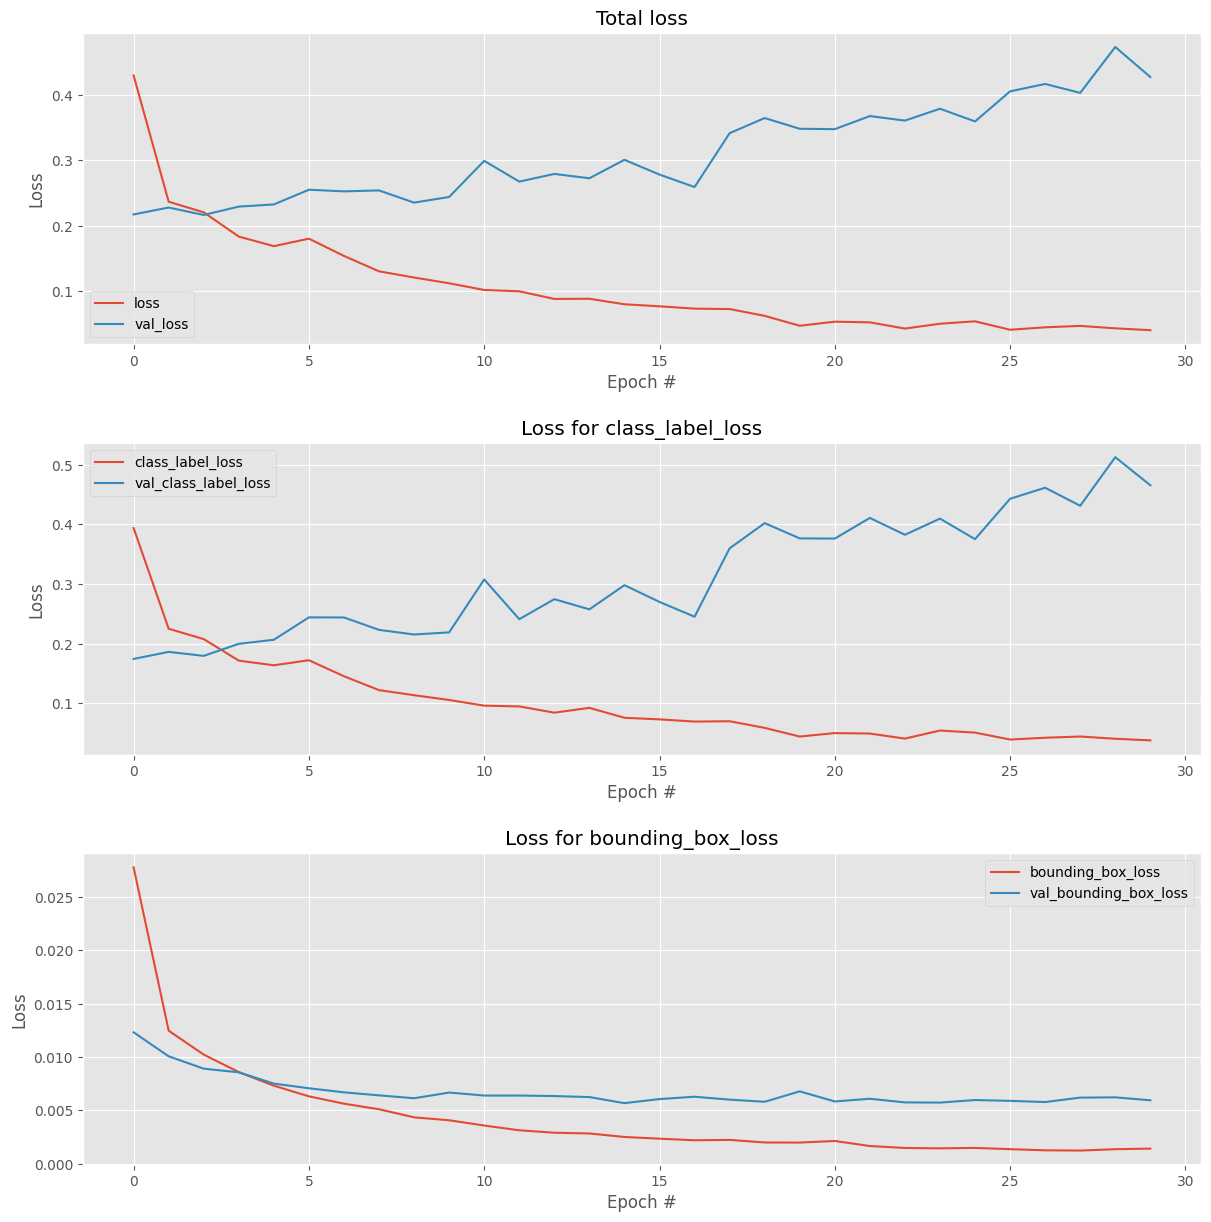

In [38]:
plot_loss(model_name='vgg16_model_v6', num_epochs=30)

Accuracy Plot

Final epoch training class label accurracy during vgg16_model_v6 training: 0.9861111044883728
Final epoch validation class label accurracy during vgg16_model_v6 training: 0.9230769276618958


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

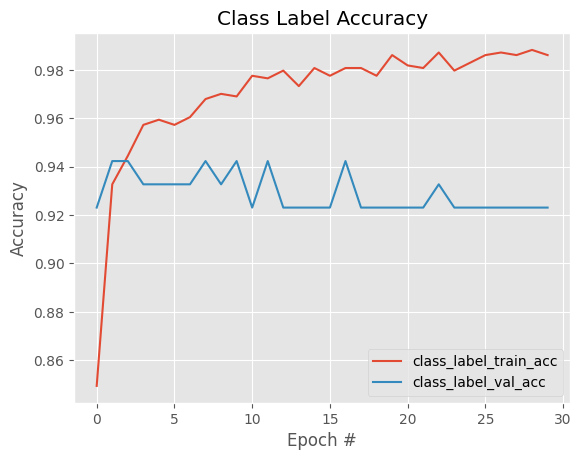

In [39]:
plot_accuracy(model_name='vgg16_model_v6', num_epochs=30)

In [40]:
result_val = evaluate_val(model=vgg16_model_v6, model_name='vgg16_model_v6')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/tmp/ipython-input-3362436508.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lbl = int(np.argmax(labelPred, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')
/usr/local/lib/python3.12/dist-packages/mean_average_precision/mean_average_precision_2d.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.match_table[c] = pd.concat([self.match_table[c], match_table], axis=0, join='outer')


VOC PASCAL mAP for vgg16_model_v6 validation data: 0.42470744252204895
VOC PASCAL mAP in all points for vgg16_model_v6 validation data: 0.4135635495185852
COCO mAP for vgg16_model_v6 validation data: 0.5560603141784668
Average inference time for vgg16_model_v6 validation data: 0.09746018510598403


Infernce , Testing of model 

In [42]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import os
import time

In [ ]:
MODEL_PATH = "Models/vgg16_model_v6.h5"
model = load_model(MODEL_PATH)
CLASS_NAMES = {0: "Crop", 1: "Weed"}
CLASS_COLORS = {0: (0, 255, 0), 1: (0, 0, 255)}

In [ ]:
def predict_image(image_path, display=True, save_path=None):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    original_image = cv2.imread(image_path)
    original_height, original_width = original_image.shape[:2]
    start_time = time.time()
    (bboxPred, labelPred) = model.predict(image_array, verbose=0)
    inference_time = time.time() - start_time
    (startX, startY, endX, endY) = bboxPred[0]
    startX = int(startX * original_width)
    startY = int(startY * original_height)
    endX = int(endX * original_width)
    endY = int(endY * original_height)
    class_idx = int(np.argmax(labelPred, axis=1)[0])
    confidence = float(np.max(labelPred) * 100)
    class_name = CLASS_NAMES.get(class_idx, f"Class {class_idx}")
    color = CLASS_COLORS.get(class_idx, (255, 255, 255))
    annotated_image = original_image.copy()
    cv2.rectangle(annotated_image, (startX, startY), (endX, endY), color, 3)
    label = f"{class_name}: {confidence:.2f}%"
    (label_width, label_height), baseline = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2
    )
    label_y = max(startY - 10, label_height + 10)
    cv2.rectangle(
        annotated_image,
        (startX, label_y - label_height - 10),
        (startX + label_width + 10, label_y),
        color,
        -1
    )
    cv2.putText(
        annotated_image,
        label,
        (startX + 5, label_y - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 255, 255),
        2
    )

    print(f"Prediction: {class_name}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Bounding Box: ({startX}, {startY}) to ({endX}, {endY})")
    print(f"Inference Time: {inference_time:.4f} seconds")
    print(f"\nClass Probabilities:")
    
    for idx in range(labelPred.shape[1]):
        prob = labelPred[0][idx] * 100
        print(f"  {CLASS_NAMES.get(idx, f'Class {idx}')}: {prob:.2f}%")
    print(f"{'='*60}\n")
    if display:
        plt.figure(figsize=(12, 8))
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        plt.imshow(annotated_image_rgb)
        plt.axis('off')
        plt.title(f"Detection: {class_name} ({confidence:.2f}%)", fontsize=14)
        plt.tight_layout()
        plt.show()
    if save_path:
        cv2.imwrite(save_path, annotated_image)
        print(f"Annotated image saved to: {save_path}")
    results = {
        'image_path': image_path,
        'class': class_name,
        'class_idx': class_idx,
        'confidence': confidence,
        'bounding_box': {
            'x_min': startX,
            'y_min': startY,
            'x_max': endX,
            'y_max': endY
        },
        'all_probabilities': {
            CLASS_NAMES.get(i, f'Class {i}'): float(labelPred[0][i] * 100)
            for i in range(labelPred.shape[1])
        },
        'inference_time': inference_time,
        'annotated_image': annotated_image
    }

    return results

In [ ]:
def predict_multiple_images(image_paths, display=True, save_dir=None):
    all_results = []
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for image_path in image_paths:
        try:
            save_path = None
            if save_dir:
                filename = os.path.basename(image_path)
                name, ext = os.path.splitext(filename)
                save_path = os.path.join(save_dir, f"{name}_annotated{ext}")
            results = predict_image(image_path, display=display, save_path=save_path)
            all_results.append(results)

        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            continue

    return all_results

def predict_from_folder(folder_path, output_folder=None, display=False):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if os.path.splitext(f.lower())[1] in image_extensions
    ]

    print(f"\nFound {len(image_files)} images in {folder_path}")
    results = predict_multiple_images(image_files, display=display, save_dir=output_folder)
    if results:
        crop_count = sum(1 for r in results if r['class'] == 'Crop')
        weed_count = sum(1 for r in results if r['class'] == 'Weed')
        avg_confidence = np.mean([r['confidence'] for r in results])
        avg_inference_time = np.mean([r['inference_time'] for r in results])
        
        print(f"Total Images Processed: {len(results)}")
        print(f"Crops Detected: {crop_count} ({crop_count/len(results)*100:.1f}%)")
        print(f"Weeds Detected: {weed_count} ({weed_count/len(results)*100:.1f}%)")
        print(f"Average Confidence: {avg_confidence:.2f}%")
        print(f"Average Inference Time: {avg_inference_time:.4f} seconds")
        print(f"{'='*60}\n")

    return results

Object Detection Inference Script Ready!

USAGE EXAMPLES:

1. Single Image Prediction:
   results = predict_image('/path/to/image.jpeg')

2. Multiple Images:
   image_paths = ['/path/img1.jpeg', '/path/img2.jpeg']
   results = predict_multiple_images(image_paths)

3. Process Entire Folder:
   results = predict_from_folder('/path/to/folder', output_folder='/path/to/output')



Image: weed_1.jpeg
Prediction: Weed
Confidence: 99.95%
Bounding Box: (82, 58) to (460, 475)
Inference Time: 0.0636 seconds

Class Probabilities:
  Crop: 0.05%
  Weed: 99.95%



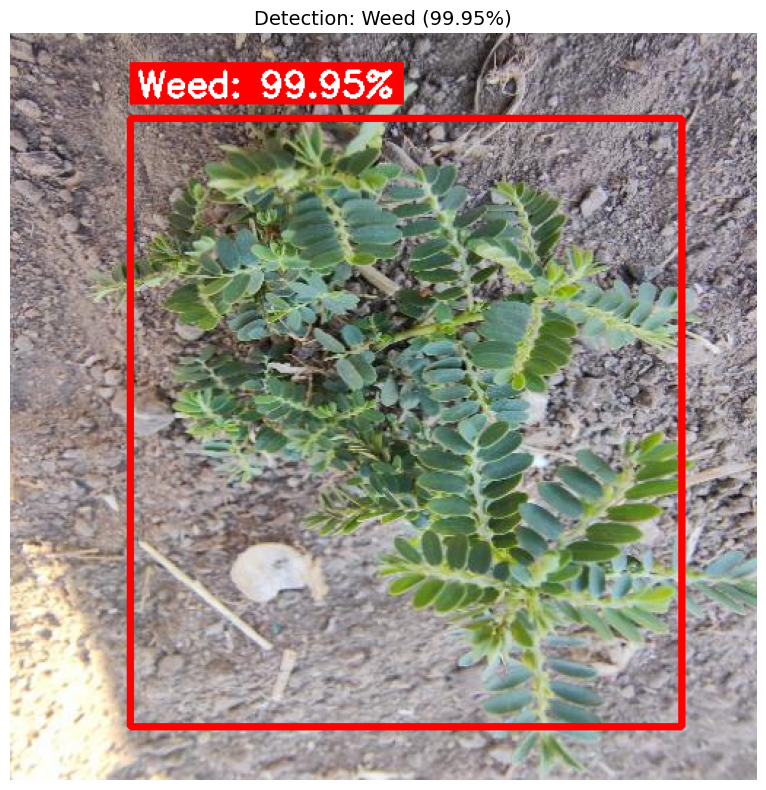

In [ ]:
if __name__ == "__main__":
    image_path = "weed_1.jpeg"
    results = predict_image(image_path)